# On reprends notre precedent model en utilisant cette fois ci un CNN en travaillant sur le sous dataset FNT .
un réseau de neurones convolutifs ( CNN , ou ConvNet ) est une classe de réseaux de neurones artificiels ( ANN ), le plus souvent appliqué pour analyser l'imagerie visuelle. Ils sont également connus sous le nom de Shift Invariant ou Space Invariant Artificial Neural Networks ( SIANN ), basés sur l'architecture à poids partagé des noyaux de convolution ou des filtres qui glissent le long des caractéristiques d'entrée et fournissent des réponses équivariantes de traduction appelées cartes de caractéristiques.Ces filtres recherchent des éléments à forte valeur visuelle (coin, bordures, contours, ...) qui sont de plus en plus complexes au fur et à mesure que l'on rajoute des couches. C'est ce qui fait que les CNN ont la capacité de reconnaitre des choses interessentes dans une image en l'analysant successivement a differents niveaux ,de facon hierarchique...


Commencons par charger les donneés


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/chars74K

EnglishFnt.tgz	EnglishHnd.tgz	EnglishImg.tgz


In [ ]:
# !tar -xzvf "/content/drive/MyDrive/chars74k.tgz" -C "/tmp/"     #[run this cell to extract tar.gz files]



import tarfile
import os 
path_to_dataset = '/content/drive/MyDrive/chars74K'


for (root,dir,files) in os.walk(path_to_dataset):
  for filename in files:
    print(os.path.join(root,filename))
    tar = tarfile.open(os.path.join(root,filename))
    tar.extractall()
  break

/content/drive/MyDrive/chars74K/EnglishFnt.tgz
/content/drive/MyDrive/chars74K/EnglishImg.tgz
/content/drive/MyDrive/chars74K/EnglishHnd.tgz


In [ ]:
!ls

drive  English	sample_data


In [ ]:
!ls ./English

Fnt  Hnd  Img


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32
datagen_args = dict(
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,#this is the trick
    rescale=1./255)
def image_data_generator(data_dir,
                       data_augment=False,
                       batch_size=BATCH_SIZE,
                       target_size=(100, 100),
                       color_mode='rgb',
                       class_mode='categorical',
                       shuffle=True,
                       subset="training"
                      ): 
  if data_augment:
      datagen = ImageDataGenerator(**datagen_args)
  else:
      datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

  generator = datagen.flow_from_directory(data_dir,
                                          target_size=target_size,
                                          color_mode=color_mode,
                                          batch_size=batch_size,
                                          shuffle=shuffle,
                                          subset=subset,
                                          class_mode=class_mode)
  return generator


In [ ]:
FNT_directory = '/content/English/Fnt/'
HND_directory = '/content/English/Hnd/Img'
Good_Img_directory = '/content/English/Img/GoodImg/Bmp'
Bad_Img_directory = '/content/English/Img/BadImag/Bmp'


In [ ]:
Fnt_train_generator = image_data_generator(FNT_directory)

Found 50406 images belonging to 62 classes.


In [ ]:
Fnt_val_generator = image_data_generator(FNT_directory,subset="validation")

Found 12586 images belonging to 62 classes.


In [ ]:
# Paramètres modifiables 
nodes = 32
epochs = 32
BATCH_SIZE = 32
import math
import keras 
from keras.backend import categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers 
from tensorflow.keras import models 
import matplotlib.pyplot as plt 

def default_layers (nodes=nodes):
  model = models.Sequential()
  model.add(layers.Conv2D(nodes,3,activation='relu',input_shape=(100,100,3)))
  model.add(layers.MaxPooling2D(2))
  model.add(layers.Flatten())
  model.add(layers.Dense(62, activation = 'softmax'))
  model.summary()
  return model



def compilation(model,loss='categorical_crossentropy',optimizer="rmsprop",metrics=['acc']):
  model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)
  return model


#### CALLBACKS
def callback(modelcheck="checkpointmodel.h5") :
  callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=8),
                  keras.callbacks.ModelCheckpoint(filepath=modelcheck,monitor='val_loss',save_best_only=True),
                  keras.callbacks.ReduceLROnPlateau(),
                  ]
  return callbacks_list

callbacks_list =callback()

def default_training(compiled_model,train_generator,val_generator,batch_size=BATCH_SIZE,epochs=epochs,verbose=2,callbacks=callbacks_list):
  history = compiled_model.fit_generator(
      train_generator,
      steps_per_epoch=math.ceil(train_generator.samples//batch_size),  
      epochs=epochs,
      callbacks=callbacks,
      validation_data=val_generator,
      validation_steps=math.ceil(val_generator.samples//batch_size),
      verbose=verbose)
  return history




### S'arrêter à temps 

On a mentionné le fait d'arrêter l'entrainement dès qu'on détectait l'overfitting, afin de limiter la décadence du modèle. 

En principe, on comprends comment faire : comparer les valeurs de loss sur le jeu de validation après chaque epoch avec les epochs précédentes et mettre un stop lorsque la loss ne s'améliore plus. 

Oui mais ... celà requiert de pouvoir faire des comparaisons sur les valeurs de l'entrainement... pendant l'entrainement ! 

Heureusement, il existe un outil pour ça ... les **Callbacks** ! 

Les callbacks sont des moyens de monitorer ce qui se passe pendant l'entrainement et d'interagir avec celui-ci pendant son exécution. Quand on lance des entrainements qui peuvent durer plusieurs jours, il est important de pouvoir contrôler les avancées régulièrement... 

Voici quelques callbacks courants implémentés dans keras : 
*   **Model ckeckpoint** : permet de sauvegarder l'état des poids à différents moments dans l'entrainement 
*    **Early stopping** : Permet d'interrompre l'entrainement quand la validation loss ne s'améliore plus 
*    **Dynamical parametyer adjustment** permet de modifier des variables, comme la learning rate ou l'optimizer, durant l'entrainement. 
*    **Logging** : permet de connaitre l'état des différentes variables durant l'entrainement et de les afficher ou de les sauvegarder. La barre de progression qui s'affiche lors d'un entrainement en fait partie ! 

On ajoute des callbacks de la manière suivante : 

- on les déclare dans une liste : 



```
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
                  keras.callbacks.ModelCheckpoint(filepath=modelcheck,monitor='val_loss',save_best_only=True),
                  keras.callbacks.ReduceLROnPlateau(),
                  ]
```
- puis on les ajoute lorsque l'on lance l'entrainement : 

```
history = compiled_model.fit_generator(
      train_generator,
      steps_per_epoch=math.ceil(train_generator.samples//batch_size),  
      epochs=epochs,
      callbacks=callbacks,
      validation_data=val_generator,
      validation_steps=math.ceil(val_generator.samples//batch_size),
      verbose=verbose)

```


In [ ]:
model =default_layers()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 76832)             0         
                                                                 
 dense (Dense)               (None, 62)                4763646   
                                                                 
Total params: 4,764,542
Trainable params: 4,764,542
Non-trainable params: 0
_________________________________________________________________


In [ ]:
compiled_model = compilation(model)

In [ ]:
FNT_history = default_training(compiled_model,Fnt_train_generator,Fnt_val_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/32
1575/1575 - 354s - loss: 1.0019 - acc: 0.7659 - val_loss: 0.5917 - val_acc: 0.8371 - lr: 0.0010 - 354s/epoch - 225ms/step
Epoch 2/32
1575/1575 - 349s - loss: 0.5520 - acc: 0.8517 - val_loss: 0.5709 - val_acc: 0.8414 - lr: 0.0010 - 349s/epoch - 221ms/step
Epoch 3/32
1575/1575 - 347s - loss: 0.4822 - acc: 0.8696 - val_loss: 0.5690 - val_acc: 0.8392 - lr: 0.0010 - 347s/epoch - 221ms/step
Epoch 4/32
1575/1575 - 345s - loss: 0.4454 - acc: 0.8793 - val_loss: 0.5701 - val_acc: 0.8456 - lr: 0.0010 - 345s/epoch - 219ms/step
Epoch 5/32
1575/1575 - 347s - loss: 0.4218 - acc: 0.8860 - val_loss: 0.5687 - val_acc: 0.8434 - lr: 0.0010 - 347s/epoch - 220ms/step
Epoch 6/32
1575/1575 - 347s - loss: 0.4056 - acc: 0.8894 - val_loss: 0.5771 - val_acc: 0.8441 - lr: 0.0010 - 347s/epoch - 220ms/step
Epoch 7/32
1575/1575 - 347s - loss: 0.3932 - acc: 0.8934 - val_loss: 0.5730 - val_acc: 0.8445 - lr: 0.0010 - 347s/epoch - 221ms/step
Epoch 8/32
1575/1575 - 348s - loss: 0.3832 - acc: 0.8959 - val_loss: 

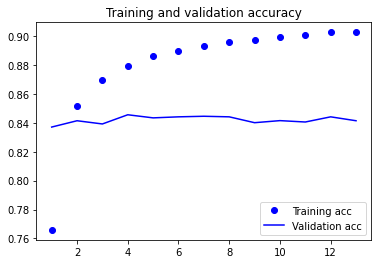

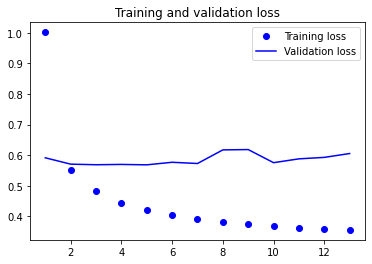

In [ ]:
acc = FNT_history.history['acc']
val_acc = FNT_history.history['val_acc']
loss = FNT_history.history['loss']
val_loss = FNT_history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
import tensorflow as tf
loaded_model = tf.keras.models.load_model('checkpointmodel.h5')
loaded_model.evaluate(Fnt_val_generator)

394/394 [==============================] - 29s 72ms/step - loss: 0.5684 - acc: 0.8435


[0.5683633089065552, 0.8434768915176392]

Sauvegarder un modèle nous permet de conserver les calculs réalisés, et de ne pas avoir à ré-entraîner un modèle avant son utilisation à chaque fois !

Remarques:
Quand j'applique les techniques de Data augmentation (si je mets "data_augment=True"), le model donne des performances tres faibles.Je suppose que les transformations ne sont pas adaptées aux caracteres.